## Explore an image

In [ ]:
if True:
  # Clone repository with example images
  # This is an example from last years. Do not put your dataset into your own repository!
  !rm -rf fyp2022-imaging
  !git clone https://github.com/vcheplygina/fyp2022-imaging.git

Cloning into 'fyp2022-imaging'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325 (from 1)
Receiving objects: 100% (325/325), 825.97 MiB | 28.91 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Updating files: 100% (309/309), done.


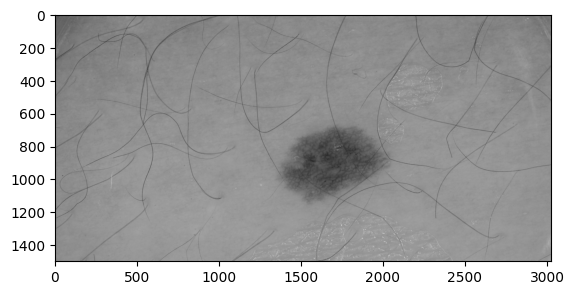

In [ ]:
# Prepare an image

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

file_im = 'fyp2022-imaging/data/example_image/ISIC_0001769.jpg'
im = plt.imread(file_im)

#Crop the image to remove the marker, convert it to RGB and display
#ADD CODE HERE

(2016, 3024, 3)
uint8
0
255
[[[157 118  87]]]


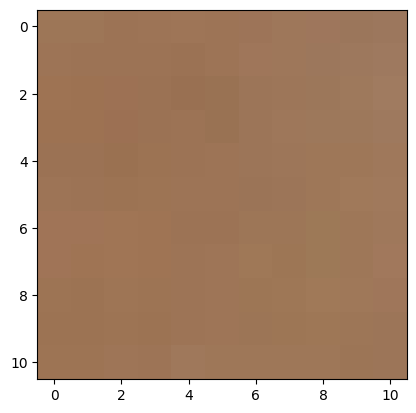

In [ ]:
# Simple steps to explore what is in the image

print(im.shape)
print(im.dtype)
print(np.min(im))
print(np.max(im))

# Show only one pixel
pixel = im[100:101,100:101,:]
print(pixel)
plt.imshow(pixel)

# Now display a 10x10 area of the image
# INSERT CODE HERE


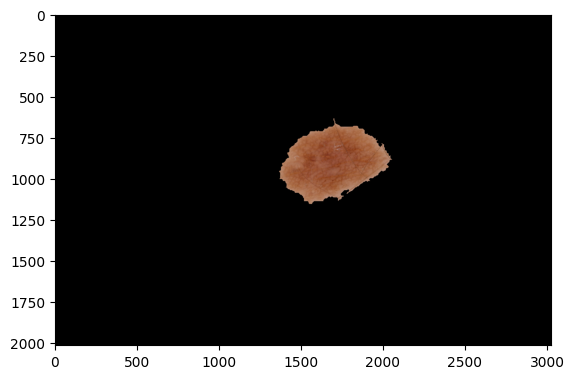

In [ ]:
# Load a "ground truth" segmentation mask for the original image (for this dataset, this is already available)
gt=plt.imread('fyp2022-imaging/data/example_segmentation/ISIC_0001769_segmentation.png')
plt.imshow(gt, cmap="gray")

# We can use the mask to only see the lesion
im2 = im.copy()
im2[gt==0] = 0

# Display
plt.imshow(im2)


In [ ]:
# Try the HSV color representation
from skimage.color import rgb2hsv

hsv_im = rgb2hsv(im)

# Inspect the channels one by one / display them side by side.
# INSERT CODE HERE


**QUESTION:** Looking at these channels one by one, what do you notice that could help with preprocessing the image?

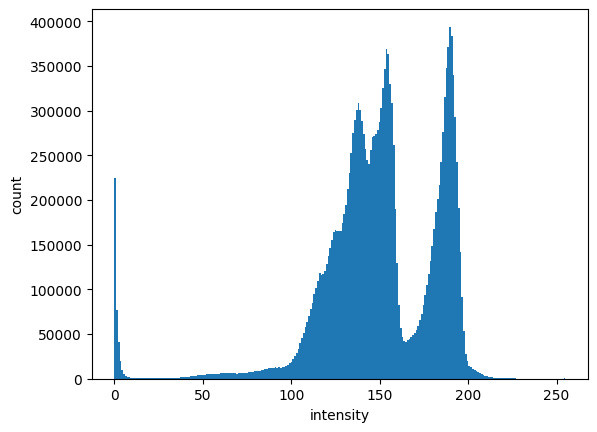

In [ ]:
# Look at the histogram

im_hist = plt.hist(im.flatten(), bins = 256)

# Add intensity and count labels to the plot, and show it
# INSERT CODE HERE


**QUESTION**:

Why do we need to do the flatten() operation above, instead of just im_hist = plt.hist(im2, bins = 256) ?



## Morphology

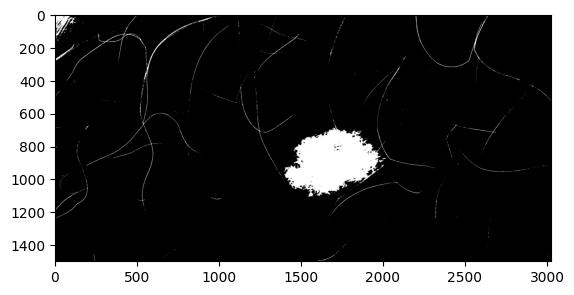

In [ ]:
# Create a mask by thresholding the image, based on the histogram (use your best guess). The segmentation will not be perfect

#INSERT CODE HERE


[[0 1 0]
 [1 1 1]
 [0 1 0]]


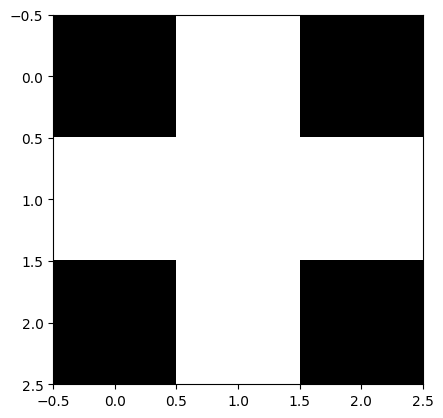

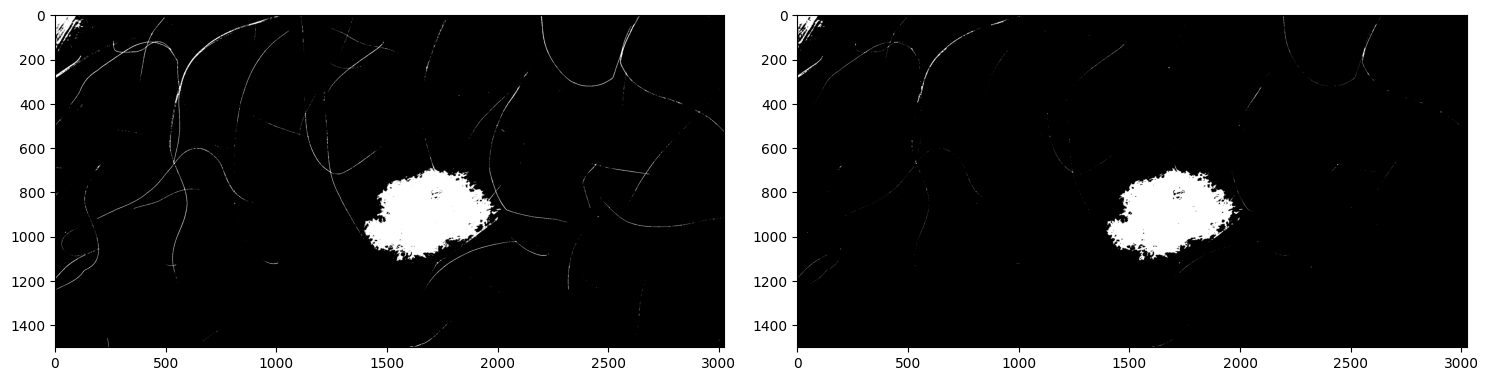

In [ ]:
# Postprocessing with morphology

from skimage import morphology

# Structural element, that we will use as a "brush". The parameter is "brush size"
struct_el = morphology.disk(1)

print(struct_el)
plt.imshow(struct_el, cmap='gray')

# Use this "brush" to erode the image
mask_eroded = morphology.binary_erosion(mask, struct_el)

# Show the original mask and the result side by side

# INSERT CODE HERE


**QUESTION**: Experiment with different parameters of the structural element, what kind of size seems to lead to better results

In [ ]:
# After erosion, there are probably some holes in the lesion. Close them by using morphology.binary_dilation and inspect the images side by side

# INSERT CODE HERE


In [ ]:
# You can try to achieve the same result in one step: morphology.binary_opening

# INSERT CODE HERE

In [ ]:
# Find the Dice score of your created mask

intersection = np.sum(mask * gt) #We are multiplying binary images, only pixels that have value 1 in both images will be left
dice = intersection*2 / (np.sum(mask) + np.sum(gt))

print(dice)

# Try experimenting with creating multiple masks by thresholding for example and combining them, can you improve the result?
# INSERT CODE HERE


**NOTE**: since you will be using Dice multiple times it's best to put it in a function so you do not duplicate code

## Area and perimeter

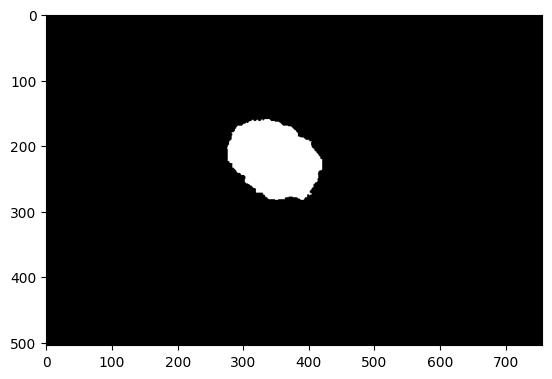

In [ ]:
# Preparing some example images

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Function to get us some example images and their masks, and resize them (just for efficiency)
def prepare_im(im_id):

  path = 'fyp2022-imaging/data/'

  im = plt.imread(path + 'example_image/' + im_id + '.jpg')
  im = resize(im, (im.shape[0] // 4, im.shape[1] // 4), anti_aliasing=True)

  gt = plt.imread(path + 'example_segmentation/' + im_id + '_segmentation.png')
  gt = resize(gt, (gt.shape[0] // 4, gt.shape[1] // 4), anti_aliasing=False)

  gt = gt>0  #This is because resizing creates some non-zero values

  return im, gt


# Get some examples

im1, mask1 = prepare_im('ISIC_0001871')
im2, mask2 = prepare_im('ISIC_0012151')

plt.imshow(mask1, cmap='gray')

In [ ]:
# Calculate the area using the image mask
# INSERT CODE HERE

In [ ]:
# Measure diameter of the lesion: measure height or width of the mask

#How many 1's in each column of the image (sum over axis 0, i.e. rows)
pixels_in_col = np.sum(mask1, axis=0)
max_pixels_in_col = np.max(pixels_in_col)
print('height is', max_pixels_in_col)

# Do the same for the rows of the image
# INSERT CODE HERE
# pixels_in_row =

height is 122


In [ ]:
# What if we want to measure diameter at an angle?

# General rule of thumb - create a simpler image first, then do the measurement

from skimage import transform
rot_im = transform.rotate(mask1, 45)
plt.imshow(rot_im, cmap='gray')

In [ ]:
# Find the perimeter - again, do not go through the pixels but make a simpler image first and then use the masks


from skimage import morphology

#Structural element, that we will use as a "brush" on our mask
struct_el = morphology.disk(1)

#plt.imshow(struct_el)

# Use this "brush" to erode the image - eat away at the borders
mask_eroded = morphology.binary_erosion(mask1, struct_el)

# Show side by side (depending on brush size, you might not see a difference visually)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(mask1, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()


# Verify the new mask is smaller
print(area)
print(np.sum(mask_eroded))


In [ ]:
# Now we can find the pixels that have value 1 in the original mask but not in the eroded mask

perimeter_im = mask1 - mask_eroded

plt.imshow(perimeter_im, cmap='gray')

# The perimeter now is just the sum of the mask
print(np.sum(perimeter_im))


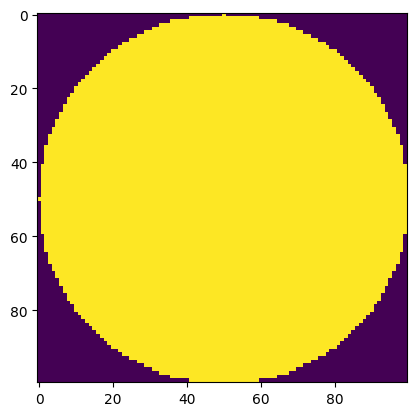

In [ ]:
# EXERCISE: Generate a binary image with a circle in it
# From https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


circle = create_circular_mask(100,100)
plt.imshow(circle, cmap='gray')

#INSERT CODE HERE

# Add some padding to the image (black rows and columns)

# Now calculate the area and perimeter and find their ratio (compactness or similar)

# Try varying the size of the circular mask and calculate these values again, what do you observe? ß